## Introduction to the Quantum Monte-Carlo trajectory method

The Quantum Monte-Carlo trajectory method is an equation of motion for a single realization of the state vector $\left|\psi(t)\right>$ for a quantum system that interacts with its environment. The dynamics of the wave function is given by the Schrodinger equation,

<center>
$\displaystyle\frac{d}{dt}\left|\psi(t)\right> = - \frac{i}{\hbar} H_{\rm eff} \left|\psi(t)\right>$
</center>

where the Hamiltonian is an effective Hamiltonian that, in addition to the system Hamiltonian $H(t)$, also contains a non-Hermitian contribution due to the interaction with the environment:

<center>
$\displaystyle H_{\rm eff}(t) = H(t) - \frac{i\hbar}{2}\sum_n c_n^\dagger c_n$
</center>

Since the effective Hamiltonian is non-Hermitian, the norm of the wavefunction is decreasing with time, which to first order in a small time step $\delta t$ is given by $\langle\psi(t+\delta t)|\psi(t+\delta t)\rangle \approx 1 - \delta p\;\;\;$, where 

<center>
$\displaystyle \delta p = \delta t \sum_n \left<\psi(t)|c_n^\dagger c_n|\psi(t)\right>$
</center>

The decreasing norm is used to determine when so-called quantum jumps are to be imposed on the dynamics, where we compare $\delta p$ to a random number in the range [0, 1]. If the norm has decreased below the randomly chosen number, we apply a "quantum jump", so that the new wavefunction at $t+\delta t$ is given by

<center>
$\left|\psi(t+\delta t)\right> = c_n \left|\psi(t)\right>/\left<\psi(t)|c_n^\dagger c_n|\psi(t)\right>^{1/2}$ 
</center>

for a randomly chosen collapse operator $c_n$, weighted so the probability that the collapse being described by the nth collapse operator is given by
    
<center>
$\displaystyle P_n = \left<\psi(t)|c_n^\dagger c_n|\psi(t)\right>/{\delta p}$ 
</center>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import scipy.linalg as lg
from scipy.optimize import curve_fit
from definations import *
from qmcwf_def import *


In [2]:
dt = 0.0001
t = 4.0000
step = int(t / dt)
fns = 100
hbar = 1 
gamma = 2
w_t = 1.0 * 2 * np.pi
nth = 0.63
tlist = np.arange(0, 4.0001, dt)
print(tlist.shape)
print(step)

(40001,)
40000


In [6]:
# creating time evolution operator when no jump happens 

H = w_t * np.dot(adagger(1), a(1))

H_eff = H - ((1j) * hbar * gamma) / 2 * np.dot(adagger(1), a(1)) 

#no-jump non-hermition time evolution 
U = np.eye(2) - ((1j) * dt) / hbar * H_eff

# jump operator
L = np.sqrt(gamma) * a(1)




In [7]:
# initialising the wave function 
psi_0 = np.array([[0], [1]])


In [8]:
# definitions for different type of trajectory evolution
def QMCWF(U, L, psi_0i, step):
    
    '''
        We use this method to find the single trajectory of the system in contact with the environment. Trajectory evolves with two 
        possibilities, first is quantum jump and second is hamiltonian evolution.
        
        U = evolution matrix
        L = jump matrix
        psi_0i = intial wavefunction
        step = number of time steps to evolve the system for
        
    '''
    # initialising
    psi_f = psi_0i   
    psi_n = psi_0i
    
    # initialising the probability of the ground and exited state
    prob_g = np.zeros(step+1)
    prob_e = np.zeros(step+1)
    
    # squaring it
    prob_g[0] = abs(psi_0i[0, 0])**2
    prob_e[0] = abs(psi_0i[1, 0])**2
    
    # evolving the system trajectory
    for t in range(step):
        size = np.dot(np.dot(psi_0i.conj().T, U.conj().T), np.dot(U, psi_0i)) # the probability of the no-jump
        jump_prob = 1.0 - float(size[0, 0])                                    # jump probability
        # print(size)
        epsilon = random.rand()                                               # generating random number                             
        if epsilon > jump_prob:
            psi_f = np.dot(U, psi_0i)                                          # evolving according to U operator for single time step
            psi_n = psi_f / lg.norm(psi_f)                                      # normalising wavefunction
            # print(psi_n)
            prob_g[t+1] = abs(psi_n[0, 0])**2
            prob_e[t+1] = abs(psi_n[1, 0])**2
            psi_0i = psi_n
        else :
            psi_f = np.dot(L, psi_0i)                                       # evolving according to jump operator
            psi_n = psi_f / lg.norm(psi_f)                                   # normalising
            prob_g[t+1] = abs(psi_n[0, 0])**2
            prob_e[t+1] = abs(psi_n[1, 0])**2
            prob_g[t+2 : step+2] = 1
            break
    return prob_g, prob_e

def QMCWF1(U, L, psi_0i, step):
    
    '''
        We use this method to find the single trajectory of the system in contact with the environment. Trajectory evolves with two 
        possibilities, first is quantum jumps from the list of given two and second is hamiltonian evolution. 
        
        U = evolution matrix
        L = jump matrices 
        psi_0i = intial wavefunction
        step = number of time steps to evolve the system for
        
    '''
    # initialising
    psi_f = psi_0i
    psi_n = psi_0i
    
    # initialising the probability of the ground and exited state
    prob_g = np.zeros(step+1)
    prob_e = np.zeros(step+1)
    prob_g[0] = abs(psi_0i[0, 0])**2
    prob_e[0] = abs(psi_0i[1, 0])**2
    
    # evolving the system trajectory
    for t in range(step):
        size = np.dot(np.dot(psi_0i.conj().T, U.conj().T), np.dot(U, psi_0i))        # the probability of the no-jump
        jump_prob = 1.0 - float(size[0, 0])                                        # jump probability
        # print(jump_prob)
        
        epsilon = random.rand()
        if epsilon > jump_prob:
            psi_f = np.dot(U, psi_0i)
            psi_n = psi_f / (lg.norm(psi_f))
            # print(abs(psi_n[1,0])**2)
            prob_g[t+1] = abs(psi_n[0, 0])**2
            prob_e[t+1] = abs(psi_n[1, 0])**2
            psi_0i = psi_n
        else :
            cum_pro = 0
            dpm = 0
            count = 0
            for K in range(2):                                              # loop over jump operators
                psi_f = np.dot(L[K, :, :], psi_0i)
                dpm = dt * np.abs(np.dot(psi_f.conj().T, psi_f ))
                # print(dt* np.abs(np.dot(psi_f.conj().T,psi_f)))
                cum_pro += dpm
                count += 1
                if epsilon < cum_pro:                                       # condition for which jump operator to choose
                    psi_f /= np.sqrt(dpm / dt)
                    psi_n = psi_f
                    prob_g[t+1] = abs(psi_n[0, 0])**2
                    prob_e[t+1] = abs(psi_n[1, 0])**2
                    psi_0i = psi_n
                    break
            if count == 1:
               prob_g[t+2 : step+2] = 1 
               
                     
    return prob_g, prob_e

def test(x, a, b):
    '''
       give the array of  form  a*exp(b*x) for the given array x.
        
    '''
    return a * np.exp(b * x)

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part


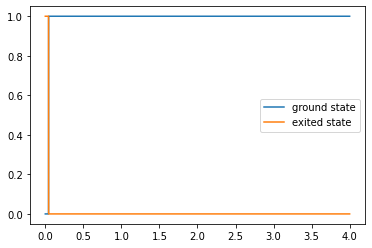

In [9]:
# single trajectory for the spontenous decay case

ground_prob, exited_prob = QMCWF(U, L, psi_0, step)
plt.plot(tlist, ground_prob, label="ground state")
plt.plot(tlist, exited_prob, label="exited state")
plt.legend()

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part


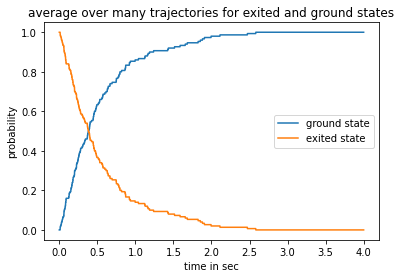

In [10]:
# number of iterations
N_iter = 150

ground_prob = np.zeros((N_iter, step+1))
exited_prob = np.zeros((N_iter, step+1))
for i in range(N_iter):
    ground_prob[i, :], exited_prob[i, :] = QMCWF(U, L, psi_0, step)

ground_avg = np.zeros(step+1)
exited_avg = np.zeros(step+1)

# print( ground_prob[:, 1])
# print(exited_prob[:, 1])
for i in range(step+1):
    ground_avg[i] = np.sum(ground_prob[:, i])/N_iter
    exited_avg[i] = np.sum(exited_prob[:, i])/N_iter
    

plt.plot(tlist, ground_avg, label="ground state")
plt.plot(tlist, exited_avg, label="exited state")
plt.xlabel("time in sec")
plt.ylabel("probability")
plt.title("average over many trajectories for exited and ground states")
plt.legend()


(40001,)
(40001,)
[ 1.02885057 -1.92889186]
comparing the gamma = 2 theoretical value with the simulation, gamma =  1.9288918572357738


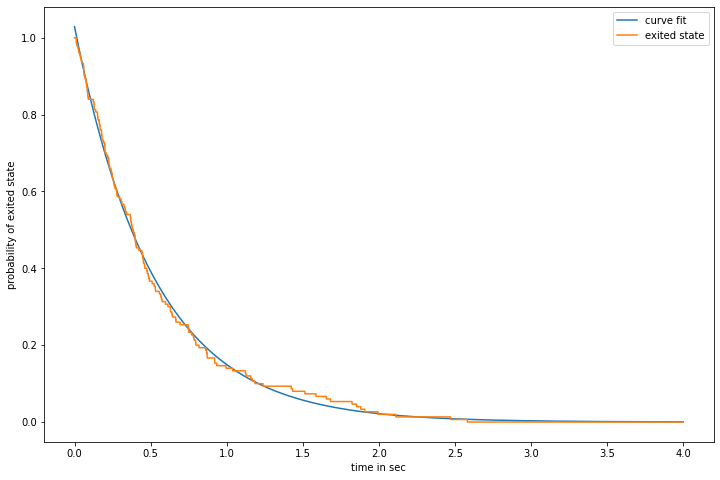

In [11]:
print(tlist.shape)
print(exited_avg.shape)
def test(x, a, b):
    '''
        give the array of  form  a*exp(b*x) for the given array x.
    '''
    return a * np.exp(b * x)
param, param_cov = curve_fit(test, tlist, exited_avg)
print(param)
fig = plt.figure(figsize=(12, 8))
plt.plot(tlist, param[0] * np.exp(param[1] * tlist), label="curve fit")
plt.plot(tlist, exited_avg, label="exited state")
plt.xlabel("time in sec")
plt.ylabel("probability of exited state")
plt.legend()
print("comparing the gamma = 2 theoretical value with the simulation, gamma = ",-param[1])

### Now for more general part of the evolution, where both  exitations and emission are happening 

* unlike above case we have more than one jump operators and each jump operator has different probabililties to happen.
* for this case we will use second function from definition **QMCWF1()**.
* to choose between which jump operator to use we are using random number and comparing with the probability of each jump operator.

In [13]:
# now for the more general part of quantum monte carlo 
psi_0 = np.array([[0], [1]])
gamma = 1 / 0.129
hbar = 1
nth = 0.063
c_1 = np.sqrt(gamma * (1 + nth)) * a(1)
c_2 = np.sqrt(gamma * nth) * adagger(1)
c_3 = np.array([c_1,c_2])
dt = 0.0001
t = 4.0000
step = int(t / dt)
tlist = np.arange(0, 4.0001, dt)
w_t = 1.0 * 2 * np.pi
H = w_t * np.dot(adagger(1), a(1))
H_eff = H - ((1j) * hbar) / 2 * (np.dot(c_1.conj().T, c_1) + np.dot(c_2.conj().T, c_2))
U = np.eye(2) - ((1j) * dt) / hbar * H_eff
U_dagger = U.conj().T

# print(tlist.shape)
# print(c_3.shape)

/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:73: ComplexWarning: Casting complex values to real discards the imaginary part


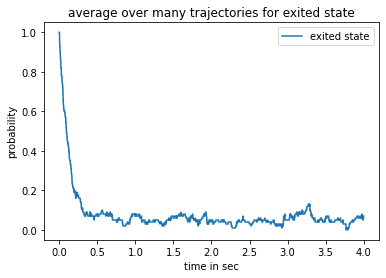

In [14]:
# number of iterations
N_iter = 100

ground_prob = np.zeros((N_iter, step+1))
exited_prob = np.zeros((N_iter, step+1))
for i in range(N_iter):
    ground_prob[i, :],exited_prob[i, :] = QMCWF1(U, c_3, psi_0, step)

ground_avg = np.zeros(step+1)
exited_avg = np.zeros(step+1)

# print( ground_prob[:, 1])
# print(exited_prob[:, 1])
for i in range(step+1):
    ground_avg[i] = np.sum(ground_prob[:, i]) / N_iter
    exited_avg[i] = np.sum(exited_prob[:, i]) / N_iter


# plt.plot(tlist, ground_avg, label="ground state")
plt.plot(tlist, exited_avg, label="exited state")
plt.xlabel("time in sec")
plt.ylabel("probability")
plt.title("average over many trajectories for exited state")
plt.legend()

[ 0.9458956  -6.79940089]
comparing the gamma = 7.752 theoretical value with the simulation =  6.799400892213993


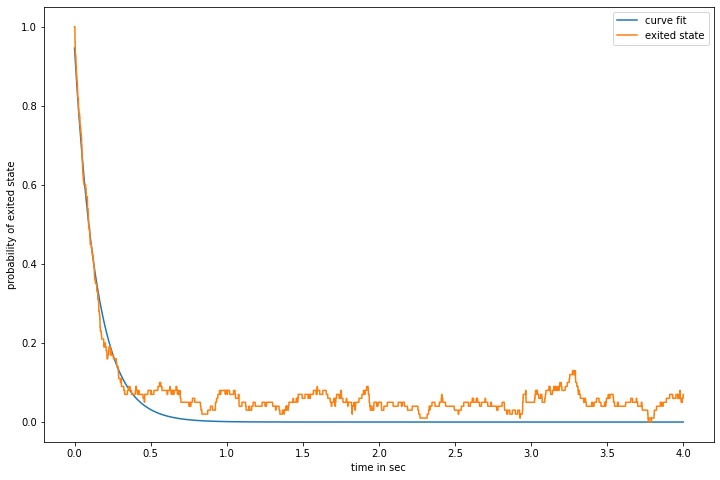

In [15]:
param, param_cov = curve_fit(test, tlist, exited_avg)
print(param)
fig = plt.figure(figsize=(12, 8))
plt.plot(tlist, param[0] * np.exp(param[1] * tlist), label="curve fit")
plt.plot(tlist, exited_avg, label="exited state")
plt.xlabel("time in sec")
plt.ylabel("probability of exited state")
plt.legend()
print("comparing the gamma = 7.752 theoretical value with the simulation = ", -param[1])

### solving master's equantion directly

In [191]:
psi_0 = np.array([[0], [1]])
rho = np.kron(psi_0.T,psi_0)/lg.norm(psi_0)
print(rho)
H = w_t * np.dot(adagger(1),a(1))

def density1(rho):
    n = np.dot(adagger(1),a(1))
    a_arho = np.dot(np.dot(adagger(1),a(1)),rho)
    rhoa_a = np.dot(np.dot(rho,adagger(1)),a(1))
    arhoa_ = np.dot(np.dot(a(1),rho),adagger(1))
    aa_rho = np.dot(np.dot(a(1),adagger(1)),rho)
    rhoaa_ = np.dot(np.dot(rho,a(1)),adagger(1))
    a_rhoa = np.dot(np.dot(adagger(1),rho),a(1))

    first_n1 = a_arho + rhoa_a -2 * arhoa_
    second_n = aa_rho + rhoaa_ -2 * a_rhoa
    L = -gamma*(nth + 1)/2 * first_n1 - gamma * nth * second_n
    #print(L)
    H_new = -(1j)/hbar * (np.dot(H,rho) - np.dot(rho,H))
    rho_dot = np.zeros([2,2])
    rho_dot = H_new + L
    #print(rho_dot)
    
    rho_new = rho_dot
    return rho_new
print(density1(rho))

[[0. 0.]
 [0. 1.]]
[[ 3.26+0.j  0.  +0.j]
 [ 0.  +0.j -3.26+0.j]]


4000
[[0. 0.]
 [0. 1.]]
[[0. 0.]
 [0. 1.]]
[[0.0032506 0.       ]
 [0.        0.9967494]]
[[0.00648772 0.        ]
 [0.         0.99351228]]
[[0.00971136 0.        ]
 [0.         0.99028864]]
[[0.01292154 0.        ]
 [0.         0.98707846]]
[[0.01611825 0.        ]
 [0.         0.98388175]]
[[0.0193015 0.       ]
 [0.        0.9806985]]
[[0.02247129 0.        ]
 [0.         0.97752871]]
[[0.02562763 0.        ]
 [0.         0.97437237]]
[[0.02877052 0.        ]
 [0.         0.97122948]]
[[0.03189997 0.        ]
 [0.         0.96810003]]
[[0.03501599 0.        ]
 [0.         0.96498401]]


/home/pi/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


[[0.03811858 0.        ]
 [0.         0.96188142]]
[[0.04120775 0.        ]
 [0.         0.95879225]]
[[0.0442835 0.       ]
 [0.        0.9557165]]
[[0.04734585 0.        ]
 [0.         0.95265415]]
[[0.05039479 0.        ]
 [0.         0.94960521]]
[[0.05343034 0.        ]
 [0.         0.94656966]]
[[0.05645251 0.        ]
 [0.         0.94354749]]
[[0.0594613 0.       ]
 [0.        0.9405387]]
[[0.06245672 0.        ]
 [0.         0.93754328]]
[[0.06543879 0.        ]
 [0.         0.93456121]]
[[0.06840751 0.        ]
 [0.         0.93159249]]
[[0.07136289 0.        ]
 [0.         0.92863711]]
[[0.07430494 0.        ]
 [0.         0.92569506]]
[[0.07723367 0.        ]
 [0.         0.92276633]]
[[0.0801491 0.       ]
 [0.        0.9198509]]
[[0.08305124 0.        ]
 [0.         0.91694876]]
[[0.08594009 0.        ]
 [0.         0.91405991]]
[[0.08881567 0.        ]
 [0.         0.91118433]]
[[0.09167799 0.        ]
 [0.         0.90832201]]
[[0.09452706 0.        ]
 [0.         0.905

[[0.38601212 0.        ]
 [0.         0.61398788]]
[[0.38721675 0.        ]
 [0.         0.61278325]]
[[0.38841354 0.        ]
 [0.         0.61158646]]
[[0.38960253 0.        ]
 [0.         0.61039747]]
[[0.39078377 0.        ]
 [0.         0.60921623]]
[[0.3919573 0.       ]
 [0.        0.6080427]]
[[0.39312316 0.        ]
 [0.         0.60687684]]
[[0.3942814 0.       ]
 [0.        0.6057186]]
[[0.39543206 0.        ]
 [0.         0.60456794]]
[[0.39657519 0.        ]
 [0.         0.60342481]]
[[0.39771082 0.        ]
 [0.         0.60228918]]
[[0.398839 0.      ]
 [0.       0.601161]]
[[0.39995978 0.        ]
 [0.         0.60004022]]
[[0.40107319 0.        ]
 [0.         0.59892681]]
[[0.40217928 0.        ]
 [0.         0.59782072]]
[[0.40327809 0.        ]
 [0.         0.59672191]]
[[0.40436967 0.        ]
 [0.         0.59563033]]
[[0.40545406 0.        ]
 [0.         0.59454594]]
[[0.40653129 0.        ]
 [0.         0.59346871]]
[[0.40760141 0.        ]
 [0.         0.5923985

[[0.50619509 0.        ]
 [0.         0.49380491]]
[[0.50659135 0.        ]
 [0.         0.49340865]]
[[0.50698489 0.        ]
 [0.         0.49301511]]
[[0.50737574 0.        ]
 [0.         0.49262426]]
[[0.5077639 0.       ]
 [0.        0.4922361]]
[[0.50814941 0.        ]
 [0.         0.49185059]]
[[0.50853226 0.        ]
 [0.         0.49146774]]
[[0.5089125 0.       ]
 [0.        0.4910875]]
[[0.50929012 0.        ]
 [0.         0.49070988]]
[[0.50966515 0.        ]
 [0.         0.49033485]]
[[0.51003761 0.        ]
 [0.         0.48996239]]
[[0.51040752 0.        ]
 [0.         0.48959248]]
[[0.51077488 0.        ]
 [0.         0.48922512]]
[[0.51113973 0.        ]
 [0.         0.48886027]]
[[0.51150207 0.        ]
 [0.         0.48849793]]
[[0.51186193 0.        ]
 [0.         0.48813807]]
[[0.51221932 0.        ]
 [0.         0.48778068]]
[[0.51257425 0.        ]
 [0.         0.48742575]]
[[0.51292675 0.        ]
 [0.         0.48707325]]
[[0.51327683 0.        ]
 [0.         0

[[0.54527635 0.        ]
 [0.         0.45472365]]
[[0.54540451 0.        ]
 [0.         0.45459549]]
[[0.54553179 0.        ]
 [0.         0.45446821]]
[[0.54565821 0.        ]
 [0.         0.45434179]]
[[0.54578375 0.        ]
 [0.         0.45421625]]
[[0.54590843 0.        ]
 [0.         0.45409157]]
[[0.54603227 0.        ]
 [0.         0.45396773]]
[[0.54615525 0.        ]
 [0.         0.45384475]]
[[0.54627739 0.        ]
 [0.         0.45372261]]
[[0.54639869 0.        ]
 [0.         0.45360131]]
[[0.54651916 0.        ]
 [0.         0.45348084]]
[[0.54663881 0.        ]
 [0.         0.45336119]]
[[0.54675764 0.        ]
 [0.         0.45324236]]
[[0.54687565 0.        ]
 [0.         0.45312435]]
[[0.54699285 0.        ]
 [0.         0.45300715]]
[[0.54710926 0.        ]
 [0.         0.45289074]]
[[0.54722486 0.        ]
 [0.         0.45277514]]
[[0.54733967 0.        ]
 [0.         0.45266033]]
[[0.5474537 0.       ]
 [0.        0.4525463]]
[[0.54756695 0.        ]
 [0.      

[[0.55809372 0.        ]
 [0.         0.44190628]]
[[0.55813416 0.        ]
 [0.         0.44186584]]
[[0.55817432 0.        ]
 [0.         0.44182568]]
[[0.55821421 0.        ]
 [0.         0.44178579]]
[[0.55825383 0.        ]
 [0.         0.44174617]]
[[0.55829317 0.        ]
 [0.         0.44170683]]
[[0.55833225 0.        ]
 [0.         0.44166775]]
[[0.55837106 0.        ]
 [0.         0.44162894]]
[[0.5584096 0.       ]
 [0.        0.4415904]]
[[0.55844788 0.        ]
 [0.         0.44155212]]
[[0.5584859 0.       ]
 [0.        0.4415141]]
[[0.55852366 0.        ]
 [0.         0.44147634]]
[[0.55856116 0.        ]
 [0.         0.44143884]]
[[0.55859841 0.        ]
 [0.         0.44140159]]
[[0.55863539 0.        ]
 [0.         0.44136461]]
[[0.55867213 0.        ]
 [0.         0.44132787]]
[[0.55870862 0.        ]
 [0.         0.44129138]]
[[0.55874485 0.        ]
 [0.         0.44125515]]
[[0.55878084 0.        ]
 [0.         0.44121916]]
[[0.55881659 0.        ]
 [0.         0

[[0.56211572 0.        ]
 [0.         0.43788428]]
[[0.56212868 0.        ]
 [0.         0.43787132]]
[[0.56214155 0.        ]
 [0.         0.43785845]]
[[0.56215434 0.        ]
 [0.         0.43784566]]
[[0.56216703 0.        ]
 [0.         0.43783297]]
[[0.56217964 0.        ]
 [0.         0.43782036]]
[[0.56219217 0.        ]
 [0.         0.43780783]]
[[0.5622046 0.       ]
 [0.        0.4377954]]
[[0.56221696 0.        ]
 [0.         0.43778304]]
[[0.56222922 0.        ]
 [0.         0.43777078]]
[[0.56224141 0.        ]
 [0.         0.43775859]]
[[0.56225351 0.        ]
 [0.         0.43774649]]
[[0.56226553 0.        ]
 [0.         0.43773447]]
[[0.56227746 0.        ]
 [0.         0.43772254]]
[[0.56228932 0.        ]
 [0.         0.43771068]]
[[0.56230109 0.        ]
 [0.         0.43769891]]
[[0.56231279 0.        ]
 [0.         0.43768721]]
[[0.5623244 0.       ]
 [0.        0.4376756]]
[[0.56233594 0.        ]
 [0.         0.43766406]]
[[0.56234739 0.        ]
 [0.         0

[[0.56342957 0.        ]
 [0.         0.43657043]]
[[0.56343356 0.        ]
 [0.         0.43656644]]
[[0.56343752 0.        ]
 [0.         0.43656248]]
[[0.56344146 0.        ]
 [0.         0.43655854]]
[[0.56344537 0.        ]
 [0.         0.43655463]]
[[0.56344925 0.        ]
 [0.         0.43655075]]
[[0.5634531 0.       ]
 [0.        0.4365469]]
[[0.56345693 0.        ]
 [0.         0.43654307]]
[[0.56346073 0.        ]
 [0.         0.43653927]]
[[0.56346451 0.        ]
 [0.         0.43653549]]
[[0.56346826 0.        ]
 [0.         0.43653174]]
[[0.56347198 0.        ]
 [0.         0.43652802]]
[[0.56347568 0.        ]
 [0.         0.43652432]]
[[0.56347935 0.        ]
 [0.         0.43652065]]
[[0.563483 0.      ]
 [0.       0.436517]]
[[0.56348663 0.        ]
 [0.         0.43651337]]
[[0.56349022 0.        ]
 [0.         0.43650978]]
[[0.5634938 0.       ]
 [0.        0.4365062]]
[[0.56349735 0.        ]
 [0.         0.43650265]]
[[0.56350087 0.        ]
 [0.         0.4364991

[[0.56382643 0.        ]
 [0.         0.43617357]]
[[0.56382771 0.        ]
 [0.         0.43617229]]
[[0.56382898 0.        ]
 [0.         0.43617102]]
[[0.56383024 0.        ]
 [0.         0.43616976]]
[[0.56383149 0.        ]
 [0.         0.43616851]]
[[0.56383274 0.        ]
 [0.         0.43616726]]
[[0.56383398 0.        ]
 [0.         0.43616602]]
[[0.5638352 0.       ]
 [0.        0.4361648]]
[[0.56383642 0.        ]
 [0.         0.43616358]]
[[0.56383763 0.        ]
 [0.         0.43616237]]
[[0.56383884 0.        ]
 [0.         0.43616116]]
[[0.56384003 0.        ]
 [0.         0.43615997]]
[[0.56384122 0.        ]
 [0.         0.43615878]]
[[0.5638424 0.       ]
 [0.        0.4361576]]
[[0.56384357 0.        ]
 [0.         0.43615643]]
[[0.56384473 0.        ]
 [0.         0.43615527]]
[[0.56384588 0.        ]
 [0.         0.43615412]]
[[0.56384703 0.        ]
 [0.         0.43615297]]
[[0.56384817 0.        ]
 [0.         0.43615183]]
[[0.5638493 0.       ]
 [0.        0.43

[[0.56395413 0.        ]
 [0.         0.43604587]]
[[0.56395454 0.        ]
 [0.         0.43604546]]
[[0.56395495 0.        ]
 [0.         0.43604505]]
[[0.56395535 0.        ]
 [0.         0.43604465]]
[[0.56395575 0.        ]
 [0.         0.43604425]]
[[0.56395614 0.        ]
 [0.         0.43604386]]
[[0.56395654 0.        ]
 [0.         0.43604346]]
[[0.56395693 0.        ]
 [0.         0.43604307]]
[[0.56395732 0.        ]
 [0.         0.43604268]]
[[0.5639577 0.       ]
 [0.        0.4360423]]
[[0.56395809 0.        ]
 [0.         0.43604191]]
[[0.56395847 0.        ]
 [0.         0.43604153]]
[[0.56395885 0.        ]
 [0.         0.43604115]]
[[0.56395922 0.        ]
 [0.         0.43604078]]
[[0.56395959 0.        ]
 [0.         0.43604041]]
[[0.56395996 0.        ]
 [0.         0.43604004]]
[[0.56396033 0.        ]
 [0.         0.43603967]]
[[0.5639607 0.       ]
 [0.        0.4360393]]
[[0.56396106 0.        ]
 [0.         0.43603894]]
[[0.56396142 0.        ]
 [0.         0

[[0.56399482 0.        ]
 [0.         0.43600518]]
[[0.56399495 0.        ]
 [0.         0.43600505]]
[[0.56399508 0.        ]
 [0.         0.43600492]]
[[0.56399521 0.        ]
 [0.         0.43600479]]
[[0.56399533 0.        ]
 [0.         0.43600467]]
[[0.56399546 0.        ]
 [0.         0.43600454]]
[[0.56399558 0.        ]
 [0.         0.43600442]]
[[0.56399571 0.        ]
 [0.         0.43600429]]
[[0.56399583 0.        ]
 [0.         0.43600417]]
[[0.56399596 0.        ]
 [0.         0.43600404]]
[[0.56399608 0.        ]
 [0.         0.43600392]]
[[0.5639962 0.       ]
 [0.        0.4360038]]
[[0.56399632 0.        ]
 [0.         0.43600368]]
[[0.56399644 0.        ]
 [0.         0.43600356]]
[[0.56399656 0.        ]
 [0.         0.43600344]]
[[0.56399668 0.        ]
 [0.         0.43600332]]
[[0.56399679 0.        ]
 [0.         0.43600321]]
[[0.56399691 0.        ]
 [0.         0.43600309]]
[[0.56399703 0.        ]
 [0.         0.43600297]]
[[0.56399714 0.        ]
 [0.      

[[0.56400782 0.        ]
 [0.         0.43599218]]
[[0.56400786 0.        ]
 [0.         0.43599214]]
[[0.5640079 0.       ]
 [0.        0.4359921]]
[[0.56400794 0.        ]
 [0.         0.43599206]]
[[0.56400798 0.        ]
 [0.         0.43599202]]
[[0.56400802 0.        ]
 [0.         0.43599198]]
[[0.56400806 0.        ]
 [0.         0.43599194]]
[[0.5640081 0.       ]
 [0.        0.4359919]]
[[0.56400814 0.        ]
 [0.         0.43599186]]
[[0.56400818 0.        ]
 [0.         0.43599182]]
[[0.56400822 0.        ]
 [0.         0.43599178]]
[[0.56400826 0.        ]
 [0.         0.43599174]]
[[0.5640083 0.       ]
 [0.        0.4359917]]
[[0.56400833 0.        ]
 [0.         0.43599167]]
[[0.56400837 0.        ]
 [0.         0.43599163]]
[[0.56400841 0.        ]
 [0.         0.43599159]]
[[0.56400845 0.        ]
 [0.         0.43599155]]
[[0.56400848 0.        ]
 [0.         0.43599152]]
[[0.56400852 0.        ]
 [0.         0.43599148]]
[[0.56400856 0.        ]
 [0.         0.435

[[0.56401194 0.        ]
 [0.         0.43598806]]
[[0.56401195 0.        ]
 [0.         0.43598805]]
[[0.56401196 0.        ]
 [0.         0.43598804]]
[[0.56401198 0.        ]
 [0.         0.43598802]]
[[0.56401199 0.        ]
 [0.         0.43598801]]
[[0.564012 0.      ]
 [0.       0.435988]]
[[0.56401201 0.        ]
 [0.         0.43598799]]
[[0.56401203 0.        ]
 [0.         0.43598797]]
[[0.56401204 0.        ]
 [0.         0.43598796]]
[[0.56401205 0.        ]
 [0.         0.43598795]]
[[0.56401206 0.        ]
 [0.         0.43598794]]
[[0.56401207 0.        ]
 [0.         0.43598793]]
[[0.56401209 0.        ]
 [0.         0.43598791]]
[[0.5640121 0.       ]
 [0.        0.4359879]]
[[0.56401211 0.        ]
 [0.         0.43598789]]
[[0.56401212 0.        ]
 [0.         0.43598788]]
[[0.56401213 0.        ]
 [0.         0.43598787]]
[[0.56401215 0.        ]
 [0.         0.43598785]]
[[0.56401216 0.        ]
 [0.         0.43598784]]
[[0.56401217 0.        ]
 [0.         0.435

[[0.56401324 0.        ]
 [0.         0.43598676]]
[[0.56401324 0.        ]
 [0.         0.43598676]]
[[0.56401325 0.        ]
 [0.         0.43598675]]
[[0.56401325 0.        ]
 [0.         0.43598675]]
[[0.56401325 0.        ]
 [0.         0.43598675]]
[[0.56401326 0.        ]
 [0.         0.43598674]]
[[0.56401326 0.        ]
 [0.         0.43598674]]
[[0.56401327 0.        ]
 [0.         0.43598673]]
[[0.56401327 0.        ]
 [0.         0.43598673]]
[[0.56401327 0.        ]
 [0.         0.43598673]]
[[0.56401328 0.        ]
 [0.         0.43598672]]
[[0.56401328 0.        ]
 [0.         0.43598672]]
[[0.56401329 0.        ]
 [0.         0.43598671]]
[[0.56401329 0.        ]
 [0.         0.43598671]]
[[0.56401329 0.        ]
 [0.         0.43598671]]
[[0.5640133 0.       ]
 [0.        0.4359867]]
[[0.5640133 0.       ]
 [0.        0.4359867]]
[[0.5640133 0.       ]
 [0.        0.4359867]]
[[0.56401331 0.        ]
 [0.         0.43598669]]
[[0.56401331 0.        ]
 [0.         0.435

[[0.56401364 0.        ]
 [0.         0.43598636]]
[[0.56401365 0.        ]
 [0.         0.43598635]]
[[0.56401365 0.        ]
 [0.         0.43598635]]
[[0.56401365 0.        ]
 [0.         0.43598635]]
[[0.56401365 0.        ]
 [0.         0.43598635]]
[[0.56401365 0.        ]
 [0.         0.43598635]]
[[0.56401365 0.        ]
 [0.         0.43598635]]
[[0.56401365 0.        ]
 [0.         0.43598635]]
[[0.56401366 0.        ]
 [0.         0.43598634]]
[[0.56401366 0.        ]
 [0.         0.43598634]]
[[0.56401366 0.        ]
 [0.         0.43598634]]
[[0.56401366 0.        ]
 [0.         0.43598634]]
[[0.56401366 0.        ]
 [0.         0.43598634]]
[[0.56401366 0.        ]
 [0.         0.43598634]]
[[0.56401366 0.        ]
 [0.         0.43598634]]
[[0.56401366 0.        ]
 [0.         0.43598634]]
[[0.56401367 0.        ]
 [0.         0.43598633]]
[[0.56401367 0.        ]
 [0.         0.43598633]]
[[0.56401367 0.        ]
 [0.         0.43598633]]
[[0.56401367 0.        ]
 [0.  

[[0.56401378 0.        ]
 [0.         0.43598622]]
[[0.56401378 0.        ]
 [0.         0.43598622]]
[[0.56401378 0.        ]
 [0.         0.43598622]]
[[0.56401378 0.        ]
 [0.         0.43598622]]
[[0.56401378 0.        ]
 [0.         0.43598622]]
[[0.56401378 0.        ]
 [0.         0.43598622]]
[[0.56401378 0.        ]
 [0.         0.43598622]]
[[0.56401378 0.        ]
 [0.         0.43598622]]
[[0.56401378 0.        ]
 [0.         0.43598622]]
[[0.56401378 0.        ]
 [0.         0.43598622]]
[[0.56401378 0.        ]
 [0.         0.43598622]]
[[0.56401378 0.        ]
 [0.         0.43598622]]
[[0.56401378 0.        ]
 [0.         0.43598622]]
[[0.56401378 0.        ]
 [0.         0.43598622]]
[[0.56401378 0.        ]
 [0.         0.43598622]]
[[0.56401378 0.        ]
 [0.         0.43598622]]
[[0.56401379 0.        ]
 [0.         0.43598621]]
[[0.56401379 0.        ]
 [0.         0.43598621]]
[[0.56401379 0.        ]
 [0.         0.43598621]]
[[0.56401379 0.        ]
 [0.  

[[0.56401382 0.        ]
 [0.         0.43598618]]
[[0.56401382 0.        ]
 [0.         0.43598618]]
[[0.56401382 0.        ]
 [0.         0.43598618]]
[[0.56401382 0.        ]
 [0.         0.43598618]]
[[0.56401382 0.        ]
 [0.         0.43598618]]
[[0.56401382 0.        ]
 [0.         0.43598618]]
[[0.56401382 0.        ]
 [0.         0.43598618]]
[[0.56401382 0.        ]
 [0.         0.43598618]]
[[0.56401382 0.        ]
 [0.         0.43598618]]
[[0.56401382 0.        ]
 [0.         0.43598618]]
[[0.56401382 0.        ]
 [0.         0.43598618]]
[[0.56401382 0.        ]
 [0.         0.43598618]]
[[0.56401382 0.        ]
 [0.         0.43598618]]
[[0.56401382 0.        ]
 [0.         0.43598618]]
[[0.56401382 0.        ]
 [0.         0.43598618]]
[[0.56401382 0.        ]
 [0.         0.43598618]]
[[0.56401382 0.        ]
 [0.         0.43598618]]
[[0.56401382 0.        ]
 [0.         0.43598618]]
[[0.56401382 0.        ]
 [0.         0.43598618]]
[[0.56401382 0.        ]
 [0.  

[[0.56401383 0.        ]
 [0.         0.43598617]]
[[0.56401383 0.        ]
 [0.         0.43598617]]
[[0.56401383 0.        ]
 [0.         0.43598617]]
[[0.56401383 0.        ]
 [0.         0.43598617]]
[[0.56401383 0.        ]
 [0.         0.43598617]]
[[0.56401383 0.        ]
 [0.         0.43598617]]
[[0.56401383 0.        ]
 [0.         0.43598617]]
[[0.56401383 0.        ]
 [0.         0.43598617]]
[[0.56401383 0.        ]
 [0.         0.43598617]]
[[0.56401383 0.        ]
 [0.         0.43598617]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.  

[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.  

[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.  

[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.  

[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.  

[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.  

[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.  

[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.         0.43598616]]
[[0.56401384 0.        ]
 [0.  

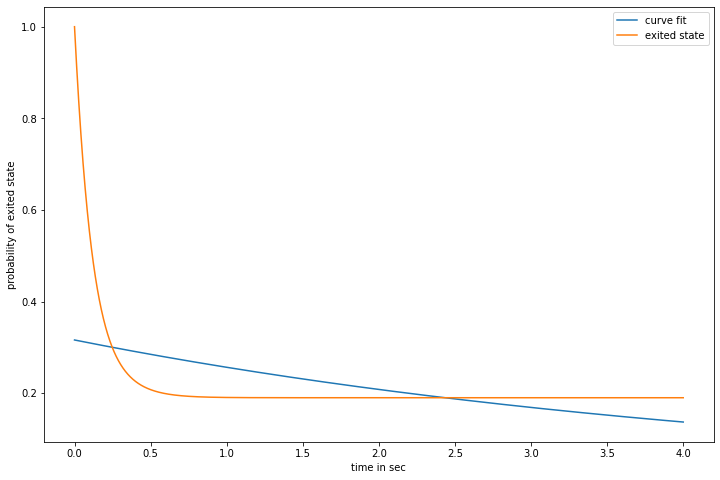

In [193]:
from scipy.integrate import odeint

dt = 0.001
t = 4.0000
tlist = np.arange(0,4.001,dt)
step = int(t/dt)
print(step)
def runge_kutta4(fun,rho,tlist):
    rho_new = np.zeros([tlist.shape[0],2,2])
    rho_new[0,:,:] = rho[:,:]
    print(rho_new[0,:,:])
    for i in np.arange(step+1):
        k1 = fun(rho_new[i,:,:], tlist[i])
        k2 = fun(rho_new[i,:,:] + dt*k1/2,tlist[i]+ dt/2)
        k3 = fun(rho_new[i,:,:] + dt*k2/2, tlist[i]+dt/2)
        k4 = fun(rho_new[i,:,:] + dt *k3, tlist[i]+dt)
        
        dx = dt*(k1+2*k2 + 2*k3+k4)/6
        rho_new[i+1,:,:] = rho_new[i,:,:] + dx/np.sqrt(lg.norm(rho_new[i,:,:]))
        print(rho_new[i,:,:])
    return rho_new

fun = lambda rho,tlist : density1(rho)
rho_new = runge_kutta4(fun, rho,tlist)

ground_prob = np.abs(rho_new[:,0,0])**2
print(ground_prob)
exited_prob = np.abs(rho_new[:,1,1])**2

def test(x, a, b):
    return a*np.exp(b*x)
 
param, param_cov = curve_fit(test, tlist, exited_prob)
print(param)
fig = plt.figure(figsize=(12, 8))
plt.plot(tlist,param[0]*np.exp(param[1]*tlist), label = "curve fit")
plt.plot(tlist,exited_prob, label = "exited state")
plt.xlabel("time in sec")
plt.ylabel("probability of exited state")
plt.legend()
print("comparing the gamma = 1 theoretical value with the simulation = ",-param[1])

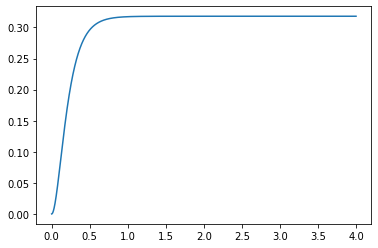

In [194]:
plt.plot(tlist,ground_prob)